In [1]:
from gaia import *
import os
from matplotlib.pyplot import *
import numpy as np
import IPython
from IPython.display import Javascript, display
from ipywidgets import *
import tkinter as tk
from tkinter import filedialog
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

ion()
from IPython.display import HTML
import seaborn as sns

# HTML('''
# <script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){ $('div.input').hide();} else { $('div.input').show();}
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the input code."></form>''')

In [3]:
from matplotlib import ticker
# Scales:
scaleT = (265.93-110.) # K
T0 = 110. # K

C0 = 920. # kg/m3

scaleV = 1e13 # Pa s
scaleA = 1.6e-4 # 1/K
scaleK = 2.3 # W/m/K
scale_t = 70e3**2/1.15e-6/3600./24./365./1e6

R0 = 1560.8

caseID = "BasalG1_Ann"
scaleD = 40. # km
scaleC = 46 # kg/m3
Tcmb = 269.224 # K
scaleT = (269.224-110.)

scale_hf = -scaleK*scaleT/scaleD # in mW because D in km


In [4]:
# Either directly
os.chdir("../" + caseID + "/")
s = Simulation()
print("Case: " + s.caseid + " Loaded Grid: " + s.grid.gridfile)
print("Got " + str(s.update()) + " new files, " + str(len(s.files))+ " in total.")
times = s.getTimes()

o = s.getAtTime(times[-1])
print("Loaded time " + str(o.time) + " and iteration " + str(s.time_iter[o.time]))

st=s.getStats()

pps=str(s.grid.nCells/s.grid.nShells)
print("cells per depth " + pps)

Case: BasalG1_Ann Loaded Grid: BasalG1_Ann.grid
Got 0 new files, 1 in total.
Loaded time 0.26848397042127975 and iteration 79027
Reading 1.0 files.
.cells per depth 776.0


40.00018239999997
1520.7998175999999
1560.8


(1520.7998176, 1560.8)

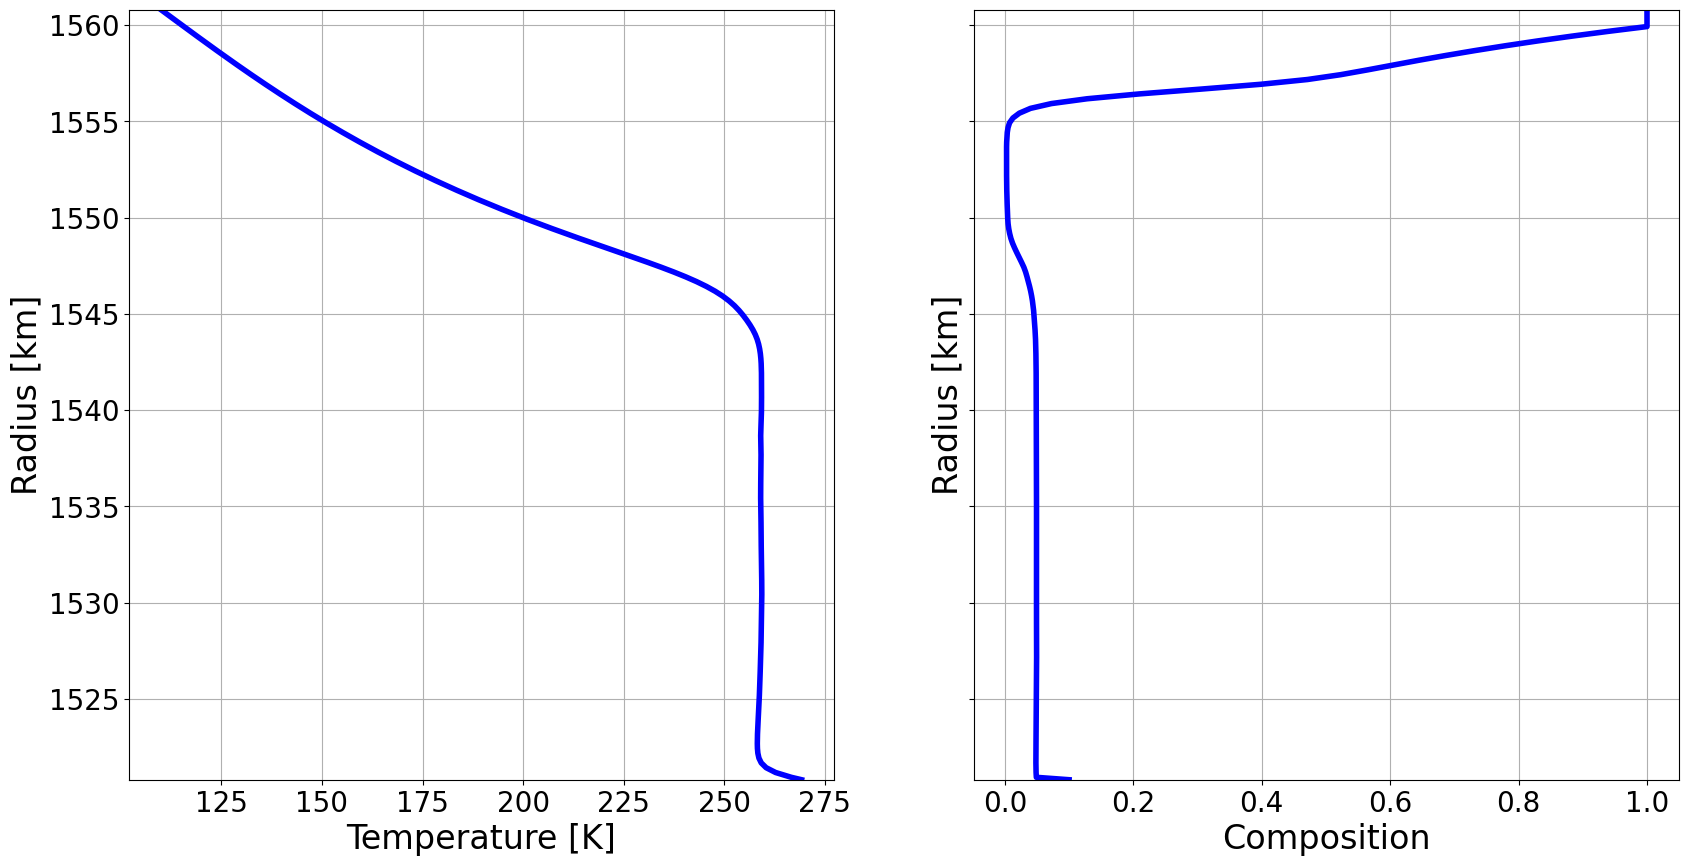

In [85]:
fig, ax = subplots(1, 2, figsize=(20,10), sharey=True)
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))

oT = getattr(o, "T")
Tprof = oT.getProfile()

if hasattr(o, 'C'):
    oC = getattr(o, "C")
    Cprof = oC.getProfile()
    
scaleD = R0/Tprof[-1,0]
print(scaleD)
print(Tprof[0,0]*scaleD)
print(Tprof[-1,0]*scaleD)

ax[0].plot(Tprof[:,2]*scaleT + T0,Tprof[:,0]*scaleD, color='blue',linewidth=4)

ax[0].set_ylabel('Radius [km]', fontsize = 24.0) # Y label
ax[0].set_xlabel('Temperature [K]', fontsize = 24) # X label
ax[0].tick_params(axis="x", labelsize=20)
ax[0].tick_params(axis="y", labelsize=20)
ax[0].grid()
ax[0].set_ylim(1560.8-scaleD,1560.8)

ax[1].plot(Cprof[:,2],Cprof[:,0]*scaleD, color='blue',linewidth=4)

ax[1].set_ylabel('Radius [km]', fontsize = 24.0) # Y label
ax[1].set_xlabel('Composition', fontsize = 24) # X label
ax[1].tick_params(axis="x", labelsize=20)
ax[1].tick_params(axis="y", labelsize=20)
ax[1].grid()
ax[1].set_ylim(1560.8-scaleD,1560.8)

In [86]:
filename = "../Data/" + caseID + "_1D_profile.txt"
file1 = open(filename,"w")

file_header = ["# Case: \n", 
               "# Column list: \n","# Column 1: Radius in km \n","# Column 2: Temperature in K \n",
               "# Column 4: Salt concentration in wt% \n"]

file1.writelines(file_header)

for i in range(len(Tprof[:,0])):
    rad = Tprof[i,0]*scaleD
    Tscaled = Tprof[i,2]*scaleT + T0
    Xscaled = Cprof[i,2]*scaleC/920*100*1.5
       
    line=str(rad) + "\t" + str(Tscaled) + "\t" + str(Xscaled) + "\n"
    file1.write(str(line))
                
file1.close()

In [87]:
filename = "../Data/" + caseID + "_2D_data.txt"
file1 = open(filename,"w")

file_header = ["# Case: \n", 
               "# Column list: \n","# Column 1: x-coordinate in km \n","# Column 2: y-coordinate in km \n",
               "# Column 3: z-coordinate in km \n","# Column 4: Temperature in K \n","# Column 5: Salt concentration in wt% \n"]

file1.writelines(file_header)

for i in range(len(oT.data)):
    Tscaled = oT.data[i]*scaleT + T0
    Xscaled = Tscaled*0.0
    if hasattr(o, 'C'):
        Xscaled = oC.data[i]*scaleC/920*100*1.5
    x_coord = s.grid.coords[i][0] * scaleD
    y_coord = s.grid.coords[i][1] * scaleD
    z_coord = s.grid.coords[i][2] * scaleD
    
    rad = (x_coord**2 + y_coord**2 + z_coord**2)**(1/2)
    
    if(rad > Tprof[-1,0]*scaleD):
        x_coord = x_coord * Tprof[-1,0]*scaleD / rad
        y_coord = y_coord * Tprof[-1,0]*scaleD / rad
        z_coord = z_coord * Tprof[-1,0]*scaleD / rad
        
    if(rad < Tprof[0,0]*scaleD):
        x_coord = x_coord * Tprof[0,0]*scaleD / rad
        y_coord = y_coord * Tprof[0,0]*scaleD / rad
        z_coord = z_coord * Tprof[0,0]*scaleD / rad
    
    line=str(x_coord) + "\t" + str(y_coord) + "\t" + str(z_coord) + "\t" + str(Tscaled[0]) + "\t" + str(Xscaled[0]) + "\n"
    file1.write(str(line))
                
file1.close()

In [1]:
# o.T.data = myAttenuationField

#np.set_printoptions(threshold=sys.maxsize)
#print(o.T.data)
#print(o.T.formatted_data[:,:,0])

x=o.grid.coords[:,0].reshape([o.grid.nShells, o.grid.nCellsPerShell[0]])
y=o.grid.coords[:,1].reshape([o.grid.nShells, o.grid.nCellsPerShell[0]])

print(o.grid.coords[:, 0].shape)
print(x.shape)
print(y.shape)

# T_res Annulus
fig = figure( figsize=(8.5, 14), dpi=180)
T_avg_per_shell = o.T.formatted_data[:,:,0].mean(axis=1)
T_res = (o.T.formatted_data[:,:,0].transpose() - T_avg_per_shell).transpose()
T_res = T_res * scaleT #+ T_surface
lowerlim = -20 # either set axis or use below #-200 #-350
#lowerlim = T_res.min()
upperlim = 20 # either set axis or use below #350 #250
#upperlim = T_res.max()
conjtourplot = contourf(x, y, T_res, np.linspace(lowerlim, upperlim,256), cmap=cm.coolwarm, extend="both")
ticksstep = 10 #110 #150
cbarticks = np.arange(T_res.min() - (T_res.min()%ticksstep), T_res.max() - (T_res.max()%ticksstep) + ticksstep, ticksstep)
cbarticks = np.arange(lowerlim, upperlim + ticksstep, ticksstep)
cb = fig.colorbar(conjtourplot, orientation="horizontal", pad=0.1, shrink=0.8, ticks=cbarticks)
cb.set_label(label="Temperature Variations [K]", fontsize=26) #22 # 28
setp(cb.ax.xaxis.get_ticklabels(), fontsize=24) #20 # 26
axes().set_aspect('equal')
axis('off')


# T
fig = figure( figsize=(4.5,7.5), dpi=180)
T = o.T.formatted_data[:,:,0]
T = T * scaleT + T0
lowerlim = 110 # either set axis or use below #-200 #-350
#lowerlim = T_res.min()
upperlim = 270 # either set axis or use below #350 #250
#upperlim = T_res.max()
cmap = sns.color_palette("plasma", as_cmap = True)


conjtourplot = contourf(x, y, T, np.linspace(lowerlim, upperlim,256), cmap = cmap, extend="both")
ticksstep = 50 #110 #150
cbarticks = np.arange(T.min() - (T.min()%ticksstep), T.max() - (T.max()%ticksstep) + ticksstep, ticksstep)
cbarticks = np.arange(lowerlim, upperlim + ticksstep, ticksstep)
cb = fig.colorbar(conjtourplot, orientation="horizontal", pad=0.1, shrink=0.8, ticks=cbarticks)
cb.set_label(label="Temperature [K]", fontsize = 10) #22 # 28
setp(cb.ax.xaxis.get_ticklabels(), fontsize = 8) #20 # 26
axes().set_aspect('equal')
axis('off')


NameError: name 'o' is not defined